# essay-2-image backend

## Importing the data

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("data/training_data.csv")

In [2]:
df.head()

,sentence,prompts
0,He was accorded a State funeral and was buried...,A solemn State funeral procession unfolds in t...
1,In American English whilst is considered to be...,A vintage-style blackboard in a classic Americ...
2,Once again she is seen performing on a compute...,"A young woman in her mid-20s, of East Asian de..."
3,Hippety Hopper returns in McKimsons Pop Im Pop.,"A vibrant cartoon rabbit, Hippety Hopper, leap..."
4,Today their programs are available on the Inte...,"A sleek, modern digital interface displaying a..."


## Data preprocessing

### Removing null values

In [3]:
df.isna().sum()

sentence    0
prompts     0
dtype: int64

In [4]:
df = df.dropna()

### Removing "PROHIBITED_CONTENT"

Although there is not much "PROHIBITED_CONTENT" (which is when the website that generates the prompt thinks that the output contains prohibited content, and thus the output), it is still advisable to remove them to prevent the model from getting too much noise in the training data.

In [6]:
df[df['prompts'] == "PROHIBITED_CONTENT"]

,sentence,prompts
22,The probability of complications can be reduce...,PROHIBITED_CONTENT
62,They are the loveliest I ever saw.,PROHIBITED_CONTENT
79,Auchterlonie was born in Sunderland County Dur...,PROHIBITED_CONTENT
92,That’s an even greater mistake.,PROHIBITED_CONTENT
214,Both characters can also throw dynamite and ca...,PROHIBITED_CONTENT
...,...,...
2883,Elimination of specific hydroxyl groups on the...,PROHIBITED_CONTENT
2898,This ebook can be shared freely but for noncom...,PROHIBITED_CONTENT
2900,He opposes samesex marriage and adoption by ho...,PROHIBITED_CONTENT
2903,However much to her annoyance it was published...,PROHIBITED_CONTENT


In [7]:
df = df[df['prompts'] != "PROHIBITED_CONTENT"]

In [8]:
df.shape

(9865, 2)

### Removing duplicated values

In [11]:
df['sentence'].duplicated().value_counts()

sentence
False    9863
True        2
Name: count, dtype: int64

The number of duplicated values in sentences are not that much, so we are going to ignore that for now, since there might be different outputs generated from the prompt generator that might benefit us in the long run, including less overfitting/underfitting models with increased variability.

In [13]:
df['prompts'].duplicated().value_counts()

prompts
True     6936
False    2929
Name: count, dtype: int64

However, the number of duplicated prompts is around 70% of the data, which is pretty significant. After some research, this might be due to overusage of the website which in the end repeatedly gave out the same output, possibly due to extensive requests. This is why we are going to remove the duplicated values from the column "prompts".

In [15]:
df = df.drop_duplicates(subset=['prompts'])

In [16]:
df.shape

(2929, 2)

### Saving the final data without duplicated or null values

In [19]:
df.to_csv("data/cleaned_training_data.csv",index=False)

### Removing stopwords & punctuations

In [20]:
import nltk
import string
from nltk.corpus import reuters, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download(['reuters','punkt','stopwords'])

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stop_words = stopwords.words('english')

In [23]:
df['prompts'] = df['prompts'].apply(lambda row: ''.join(list(filter(lambda char: char not in string.punctuation, row))))

In [24]:
df['prompts'] = df['prompts'].apply(lambda row: ' '.join(list(filter(lambda char: char not in stop_words and char != "", row.lower().split(' ')))))

In [26]:
df['sentence'] = df['sentence'].apply(lambda row: ''.join(list(filter(lambda char: char not in string.punctuation, row))))

In [27]:
df['sentence'] = df['sentence'].apply(lambda row: ' '.join(list(filter(lambda char: char not in stop_words and char != "", row.lower().split(' ')))))

In [28]:
df.head()

,sentence,prompts
0,accorded state funeral buried drayton toowoomb...,solemn state funeral procession unfolds drayto...
1,american english whilst considered pretentious...,vintagestyle blackboard classic american class...
2,seen performing computergenerated stage,young woman mid20s east asian descent stands c...
3,hippety hopper returns mckimsons pop im pop,vibrant cartoon rabbit hippety hopper leaps en...
4,today programs available internet,sleek modern digital interface displaying vibr...


## NLP Analysis

In [29]:
sentence_words = word_tokenize(' '.join(df['sentence'].values.flatten()))

In [30]:
print("SENTENCE COLUMN")
print(f"Word count: {len(sentence_words)}")
print(f"Average word length: {round(sum(list(map(len, sentence_words)))/len(sentence_words),2)}")
print(f"Vocabulary richness: {round(len(list(set(sentence_words)))/len(sentence_words)*100,2)}%")

SENTENCE COLUMN
Word count: 16235
Average word length: 6.1
Vocabulary richness: 43.62%


In [31]:
prompts_words = word_tokenize(' '.join(df['prompts'].values.flatten()))

In [32]:
print("PROMPTS COLUMN")
print(f"Word count: {len(prompts_words)}")
print(f"Average word length: {round(sum(list(map(len, prompts_words)))/len(prompts_words),2)}")
print(f"Vocabulary richness: {round(len(list(set(prompts_words)))/len(prompts_words)*100,2)}%")

PROMPTS COLUMN
Word count: 372420
Average word length: 6.57
Vocabulary richness: 4.42%


As we can see here, compared to the sentence column which has a total vocabulary richness of 43.62%, the prompts column unsurprisingly has less than 5% of vocabulary richness. This is probably due to the repetition in words used to describe the images. This means that as long as the model captures important keywords among the prompts, it can easily generate image prompts.

In [33]:
from nltk import pos_tag, ne_chunk
nltk.download(['averaged_perceptron_tagger_eng','maxent_ne_chunker','maxent_ne_chunker_tab','words','wordnet'])

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

labelling words by tags

In [34]:
tagged_sentence_words = pos_tag(sentence_words)
print(tagged_sentence_words,flush=True)

[('accorded', 'VBN'), ('state', 'NN'), ('funeral', 'JJ'), ('buried', 'VBD'), ('drayton', 'NN'), ('toowoomba', 'NN'), ('cemetery', 'JJ'), ('american', 'JJ'), ('english', 'NN'), ('whilst', 'NN'), ('considered', 'VBN'), ('pretentious', 'JJ'), ('archaic', 'NNS'), ('seen', 'VBN'), ('performing', 'VBG'), ('computergenerated', 'JJ'), ('stage', 'NN'), ('hippety', 'NN'), ('hopper', 'NN'), ('returns', 'NNS'), ('mckimsons', 'NNS'), ('pop', 'VBP'), ('im', 'JJ'), ('pop', 'NN'), ('today', 'NN'), ('programs', 'NNS'), ('available', 'JJ'), ('internet', 'JJ'), ('russian', 'JJ'), ('films', 'NNS'), ('literature', 'VBP'), ('depict', 'JJ'), ('bride', 'IN'), ('kidnapping', 'VBG'), ('caucasus', 'NN'), ('wattle', 'JJ'), ('glen', 'NN'), ('small', 'JJ'), ('primary', 'JJ'), ('school', 'NN'), ('known', 'VBN'), ('wattle', 'JJ'), ('glen', 'JJ'), ('primary', 'JJ'), ('school', 'NN'), ('majestyk', 'NN'), ('turns', 'VBZ'), ('tables', 'NNS'), ('also', 'RB'), ('small', 'JJ'), ('contingent', 'JJ'), ('cavalry', 'NN'), ('att

In [36]:
tagged_prompts_words = pos_tag(prompts_words)
print(tagged_prompts_words,flush=True)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



The IOPub data rate exceeded, thus we are going to skip this step since it's not that significant.

## Wordcloud

Wordcloud of sentence column

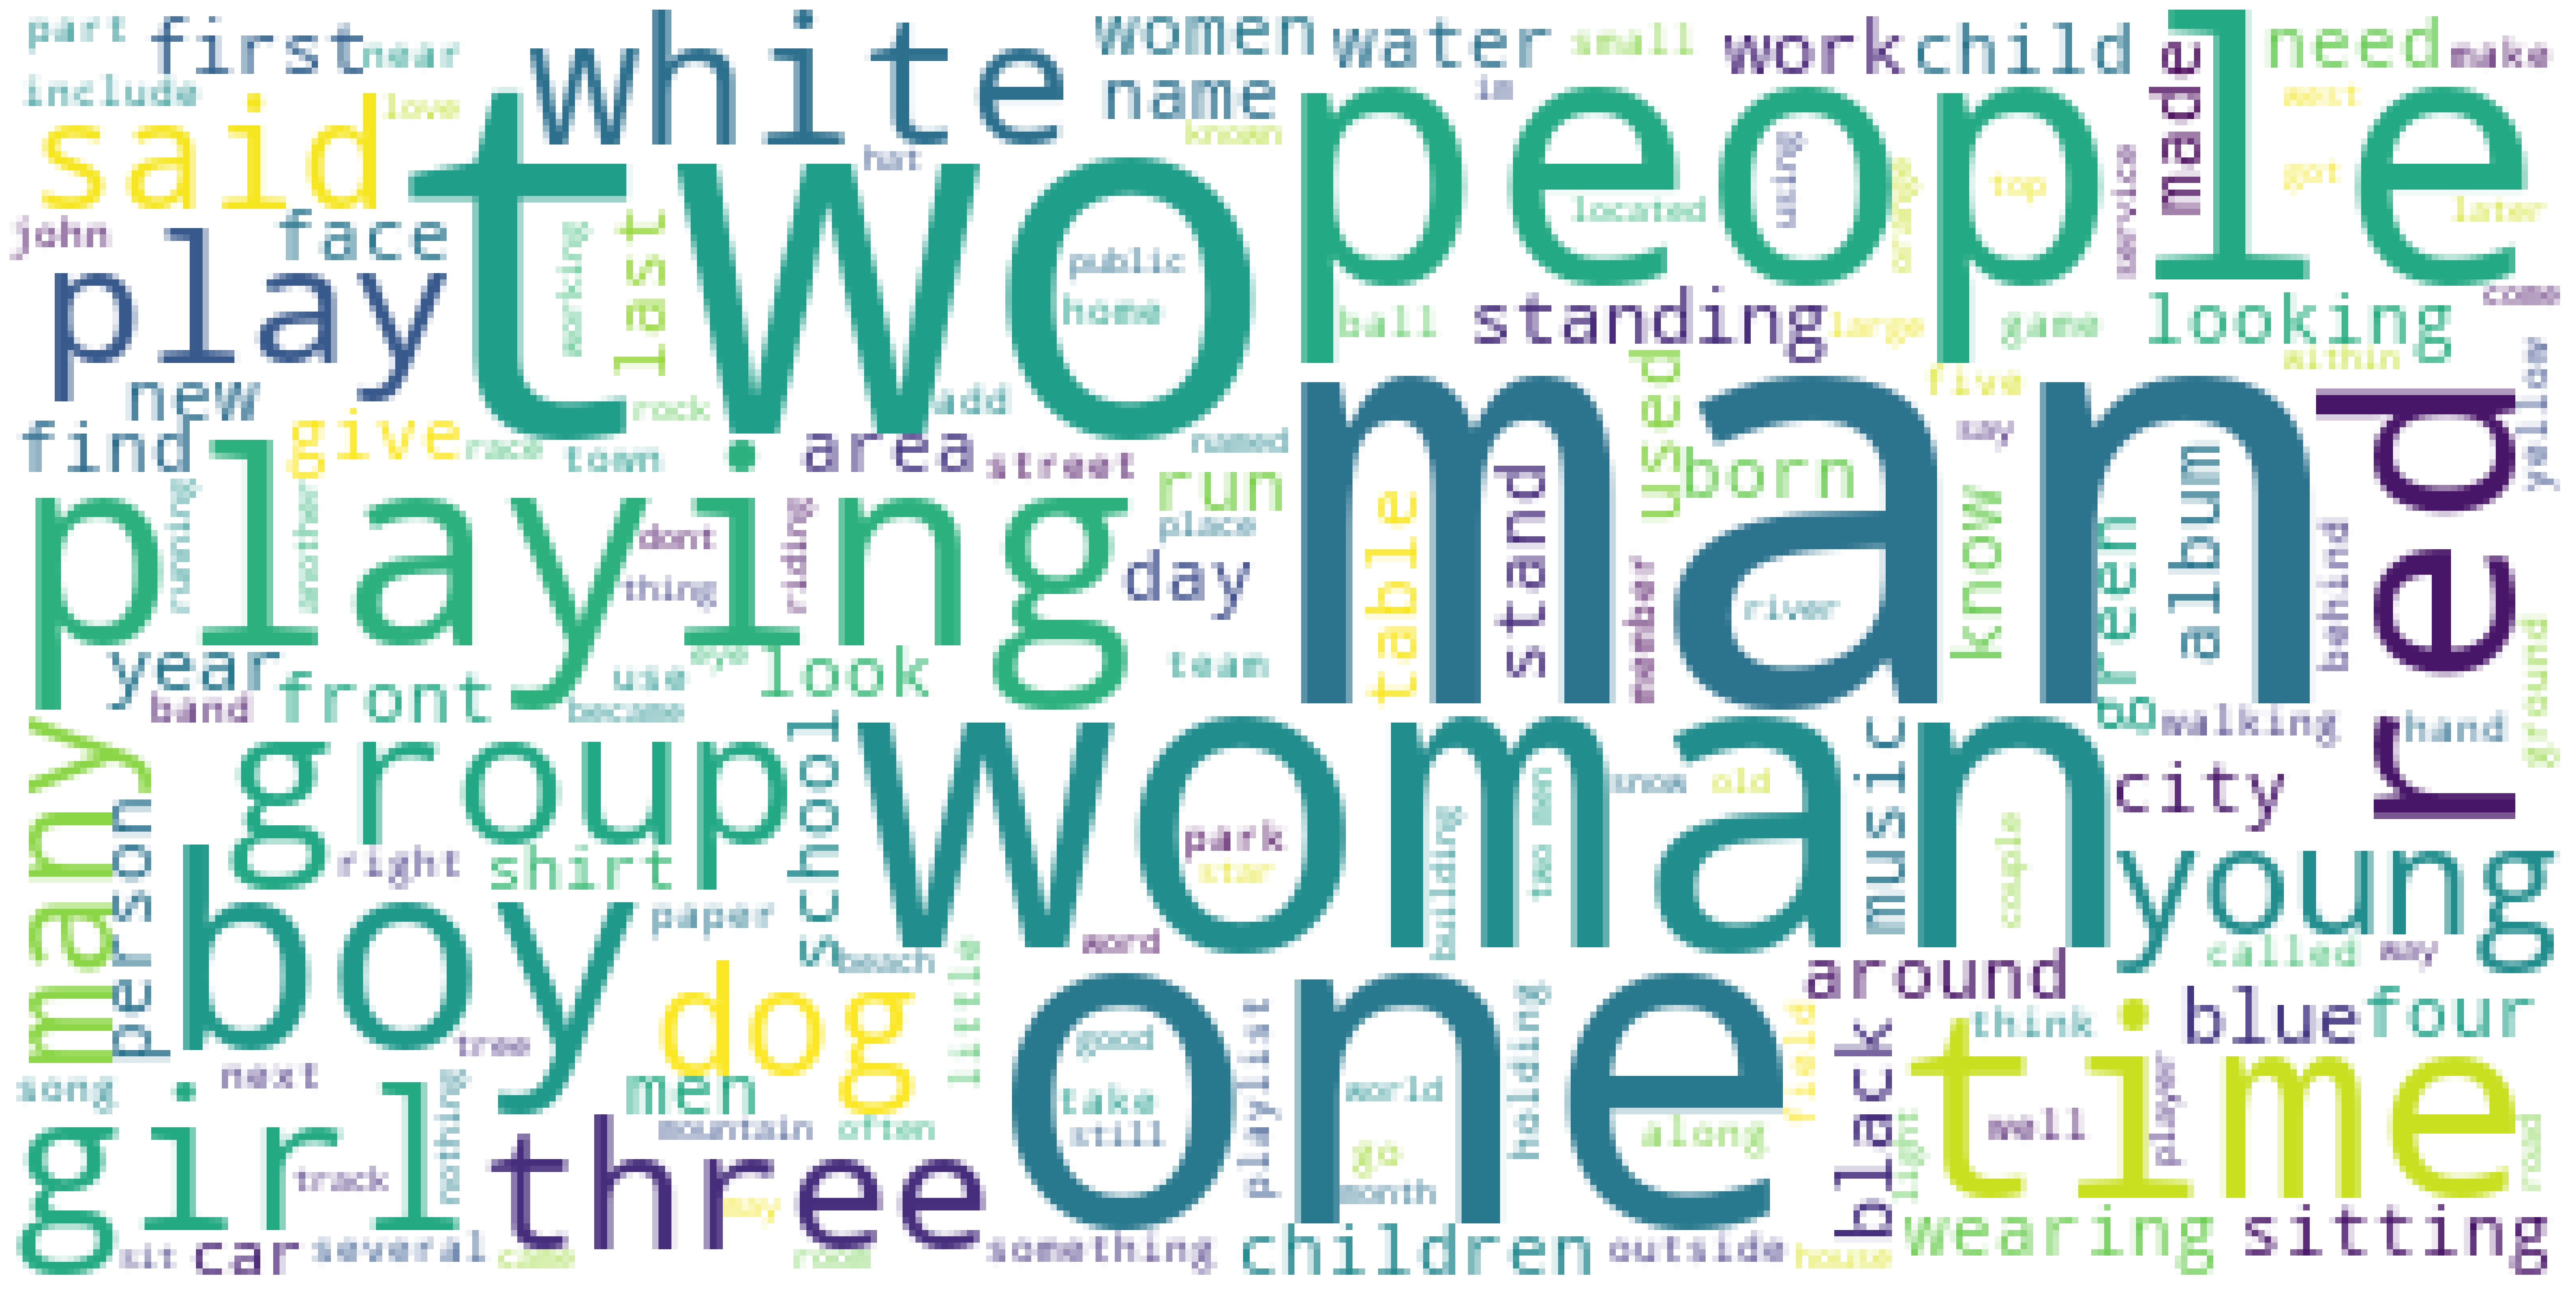

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(background_color='white').generate(' '.join(sentence_words))
plt.figure(figsize=(100,60))
plt.imshow(wc)
plt.axis('off')
plt.savefig(f'output/sentences_wordcloud.png',
            dpi = 200)

Wordcloud of prompts column

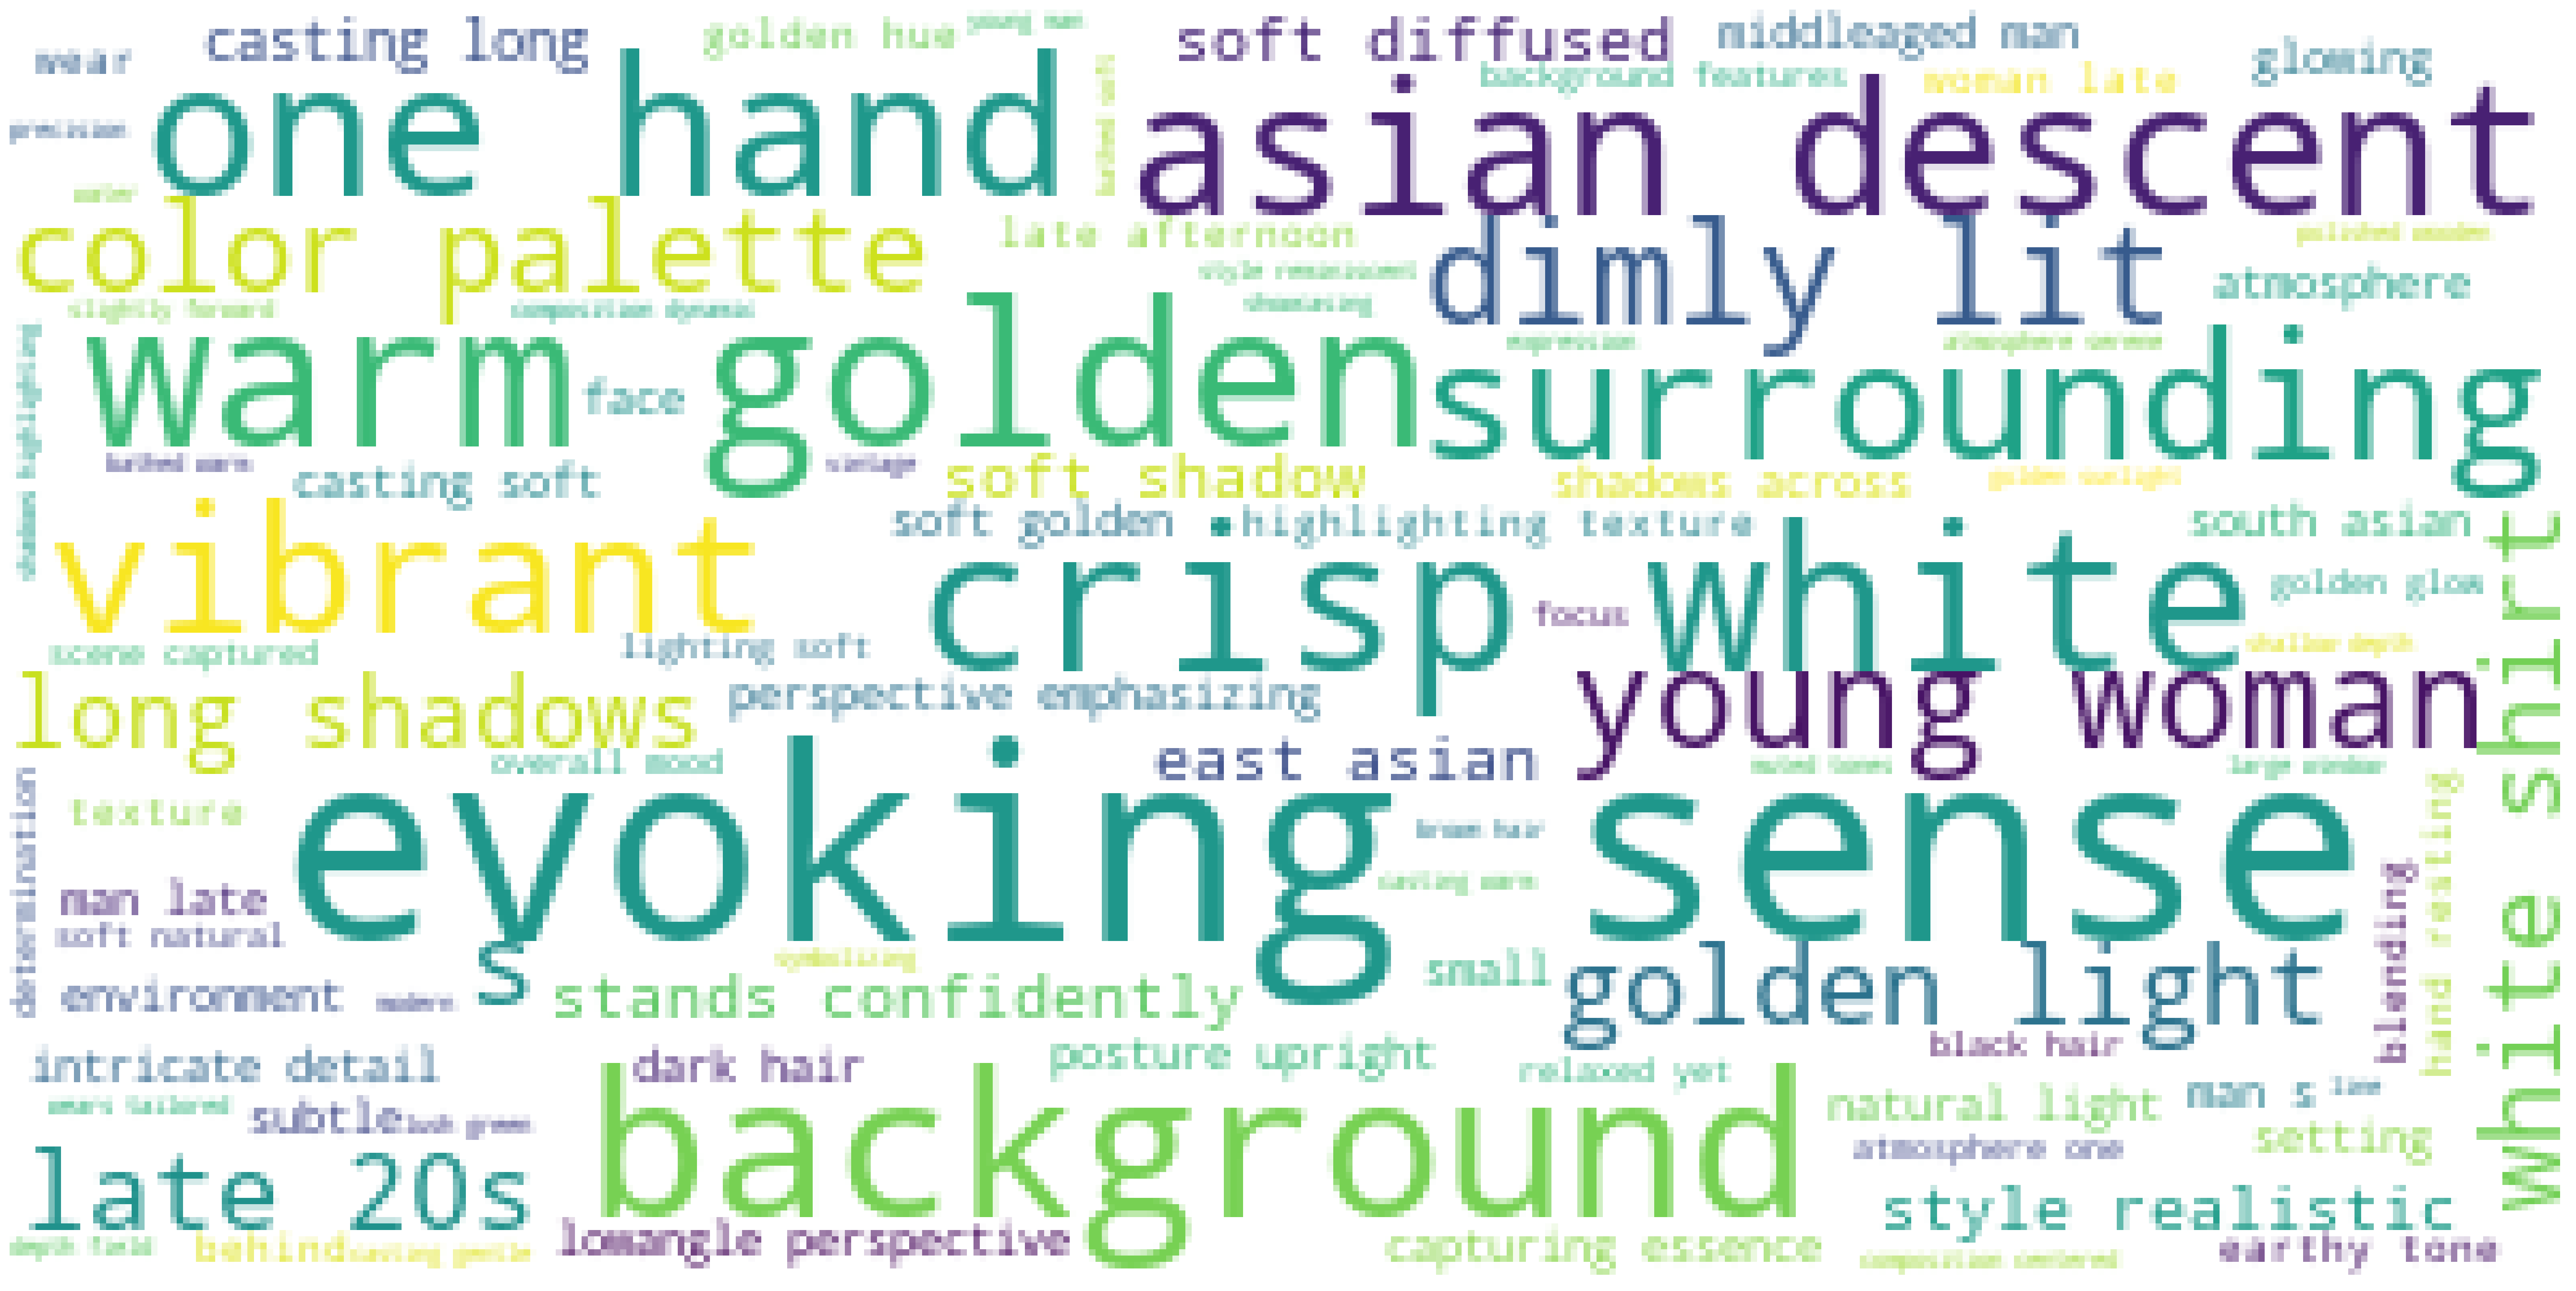

In [41]:
wc = WordCloud(background_color='white').generate(' '.join(prompts_words))
plt.figure(figsize=(100,60))
plt.imshow(wc)
plt.axis('off')
plt.savefig(f'output/prompts_wordcloud.png',
            dpi = 200)

## Words Frequency Distribution

In [42]:
from nltk.probability import FreqDist

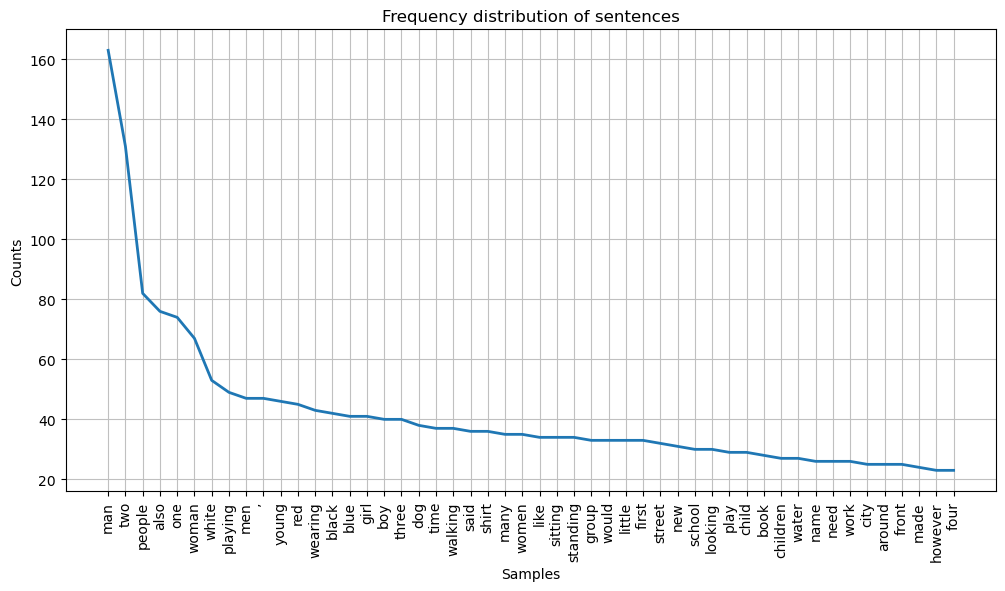

In [47]:
freq_dist = FreqDist(sentence_words)
plt.figure(figsize=(12,6))
plt.title("Frequency distribution of sentences")
freq_dist.plot(50)
plt.savefig(f'output/sentences_freqdist.png',
            dpi = 200)

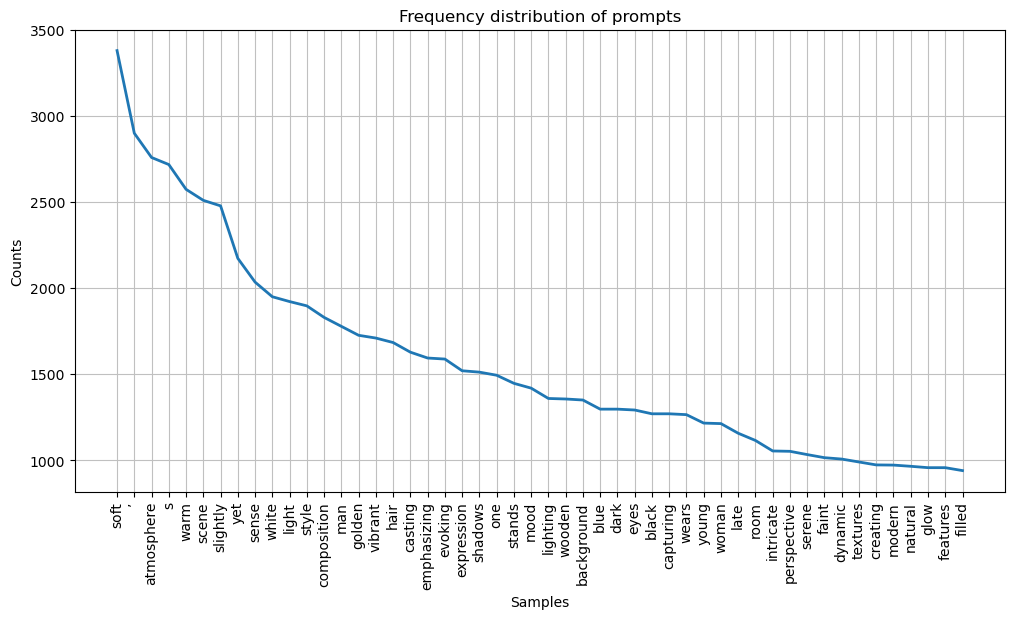

In [48]:
freq_dist = FreqDist(prompts_words)
plt.figure(figsize=(12,6))
plt.title("Frequency distribution of prompts")
freq_dist.plot(50)
plt.savefig(f'output/prompts_freqdist.png',
            dpi = 200)

# Documentation and Assumptions

As what I have observed, compared to the sentence column which has a total vocabulary richness of 43.62%, the prompts column unsurprisingly has less than 5% of vocabulary richness. This is probably due to the repetition in words used to describe the images. This means that as long as the model captures important keywords among the prompts, it can easily generate image prompts.

For the task of converting sentences into image prompts, after doing intensive research, I have decided to try out GANs which generates sentences based on the hint or input given, and also Seq2Seq models which learn and detect patterns from one text sequence to another, which is definitely more applicable for this use case.